# Intelligent denoising of Tailored MR Fingerprinting data (with smaller training set and epochs)

## Qimin Zhang and Weiwei Qi

## 1. Config

In [1]:
import numpy as np
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.regularizers import l1
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import matplotlib.pyplot as plt
import pandas as pd
from keras.utils.vis_utils import plot_model

from PIL import Image, ImageOps

import torch

from keras import models

import scipy.io

# from dfply import *

torch.manual_seed(4460)
np.random.seed(4460)

Using TensorFlow backend.


## 2. Read data and explore

In [2]:
xtrain = scipy.io.loadmat('./data/xtrain.mat')
ytrain = scipy.io.loadmat('./data/ytrain.mat')

In [3]:
assert len(xtrain['TMRF_T2']) == len(ytrain['GS_T2'])
print('The sample size is', len(xtrain['TMRF_T2']))

The sample size is 20


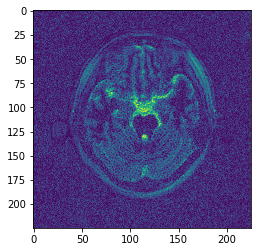

In [4]:
# Show the first image in xtrain
plt.imshow(xtrain['TMRF_T2'][1])    
plt.show()

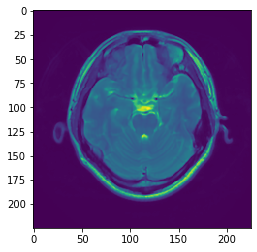

In [5]:
# Show the first image in ytrain
plt.imshow(ytrain['GS_T2'][1])    
plt.show()

(224, 224)


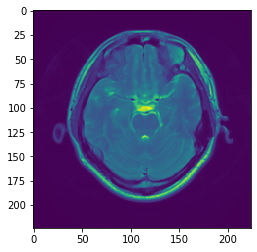

In [6]:
# With crop

print(ytrain['GS_T2'][1][0:224,0:224].shape)
plt.imshow(ytrain['GS_T2'][1][0:224,0:224])    
plt.show()

## 3. Define the model

In [7]:
def unet(pretrained_weights=None, input_size=(224, 224, 1)):
    inputs = Input(input_size)
    # conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    # conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    # pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    # conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    # conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    conv7 = Conv2D(256, 1, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 1, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    # up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
    #     UpSampling2D(size=(2, 2))(conv7))

    # up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
    #     UpSampling2D(size=(2, 2))(conv7))
    up8 = Conv2D(128, 1, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)

    # conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 1, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    # conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Conv2D(128, 1, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    # up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
    #     UpSampling2D(size=(2, 2))(conv8))
    # merge9 = concatenate([conv1, up9], axis=3)
    # conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    # conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    # conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)


    # conv10 = Conv2D(1, 1, kernel_regularizer=l1(0.0001))(conv8)
    conv10 = Conv2D(1, 1)(conv8)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(lr=1e-4), loss='mse',  metrics=['mae', 'mse'])
    print(model.summary())

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

## 4. Train the model

In [8]:
random_index = np.random.choice(len(xtrain['TMRF_T2']), 10, replace=False)

xtest = xtrain['TMRF_T2'][random_index]
ytest = ytrain['GS_T2'][random_index]

xtrain = np.delete(xtrain['TMRF_T2'], random_index, axis=0)
ytrain = np.delete(ytrain['GS_T2'], random_index, axis=0)

xtrain = np.reshape(xtrain, [10, 225, 225, 1])
ytrain = np.reshape(ytrain, [10, 225, 225, 1])
xtest = np.reshape(xtest, [10, 225, 225, 1])
ytest = np.reshape(ytest, [10, 225, 225, 1])

xtrain = xtrain[:, 0:224, 0:224, :]
ytrain = ytrain[:, 0:224, 0:224, :]
xtest = xtest[:, 0:224, 0:224, :]
ytest = ytest[:, 0:224, 0:224, :]

print(len(xtrain))
print(len(xtest))

10
10


In [9]:
from keras.callbacks import EarlyStopping

# Define paths
checkpoint_path = "unet.hdf5"

# Define model hyperparameters
EPOCHS = 20
SPEREPOCH = 20


# Setup definitions for display
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['mae'],
             label='Val Error')
    plt.ylim([0, 500])
    plt.legend()
    plt.show()


model = unet()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 128 1280        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 128 147584      conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 112, 112, 128 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

/home/wq2151/.conda/envs/BMEN4460/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [10]:
# plot_model(model, to_file='model_plot.png')

# model_checkpoint = ModelCheckpoint('unet_pepa.hdf5', monitor='loss',verbose=1, save_best_only=True)
# cp_callback =  ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1,save_best_only=True)
# cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

# cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=False,
#                               save_weights_only=True, mode='auto', period=1)

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=False,
                              save_weights_only=True, mode='auto', period=10)


callbacks_list = [cp_callback]
history = model.fit(
    xtrain, ytrain, steps_per_epoch=SPEREPOCH,
    epochs=EPOCHS, callbacks=callbacks_list, verbose=2)
print('Training done')

Epoch 1/20
 - 1923s - loss: 205592.7328 - mae: 349.4233 - mse: 205592.7188
Epoch 2/20
 - 1912s - loss: 123664.0555 - mae: 239.4204 - mse: 123664.0625
Epoch 3/20
 - 1923s - loss: 95581.7992 - mae: 173.8340 - mse: 95581.7969
Epoch 4/20
 - 1926s - loss: 80055.9965 - mae: 143.1816 - mse: 80056.0000
Epoch 5/20
 - 1924s - loss: 79276.3332 - mae: 145.0282 - mse: 79276.3203
Epoch 6/20
 - 1916s - loss: 68238.6863 - mae: 126.7547 - mse: 68238.6953
Epoch 7/20
 - 1920s - loss: 78273.7754 - mae: 146.5844 - mse: 78273.7734
Epoch 8/20
 - 1924s - loss: 55341.8348 - mae: 116.8749 - mse: 55341.8398
Epoch 9/20
 - 1924s - loss: 49481.1758 - mae: 103.2446 - mse: 49481.1758
Epoch 10/20
 - 1622s - loss: 72512.4869 - mae: 139.4632 - mse: 72512.4922

Epoch 00010: saving model to unet.hdf5
Epoch 11/20
 - 958s - loss: 47619.3285 - mae: 108.8779 - mse: 47619.3320
Epoch 12/20
 - 958s - loss: 34631.8522 - mae: 87.8010 - mse: 34631.8477
Epoch 13/20
 - 957s - loss: 29807.4627 - mae: 80.3879 - mse: 29807.4648
Epoch 14

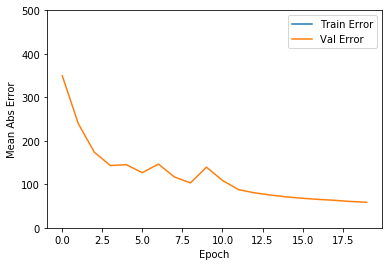

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [12]:
history_save = {'loss': history.history['loss'], 'mae': history.history['mae'], 'mse': history.history['mse']}
scipy.io.savemat('./history_invcor.mat', history_save)
plot_history(history)

# VISUALIZATION
plot_model(model, to_file='model_plot_invcor.png', show_shapes=True, show_layer_names=True)
# layer_outputs = [layer.output for layer in model.layers[:1]]
layer_outputs = [layer.output for layer in model.layers]

activation_model = models.Model(inputs=model.input,
                                outputs=layer_outputs)  # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(xtest_vis)

first_layer_activation = activations[29]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
plt.show()

dictOfactivations = {'Layer'+str(i): activations[i] for i in range(0, len(activations))}
scipy.io.savemat('./Lactivations_invcor.mat', dictOfactivations)

# TESTING
ypred = model.predict(xtest, verbose=1)
result = {'ypred_invcor': ypred, 'ytrain_deblur': ytrain}
sio.savemat('./SVPSF_128_invcor.mat', result)